# **TC5035 Proyecto Integrador**

## Maestría en Inteligencia Artificial Aplicada
#### Tecnológico de Monterrey
#### Dra. Grettel Barceló Alonso

### **Avance 1. Análisis exploratorio de datos**

**Equipo # 6 - IBM Lámparas automotrices**

| Integrantes  | Matricula |
|---------|------|
| Luis Carlos Alberto Espinosa Alvarado | A00816016 |
| Daniela Hernández Sánchez | A01733771 |
| Andrea Jelena Ramírez García | A01733905 |


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%pip install wordcloud

In [3]:
%pip install pdfplumber nltk langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 93.6 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=484345a84a52d6a79d250cc29f60c685295d2a25bb9ff69ab1d3cb2af4b6e016
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


##Código para extraer texto de todos los PDFs

In [8]:
from google.colab import drive # necesario agregar para cargar datos en Google Colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from pathlib import Path
import pdfplumber

normas_dir = Path("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Avance 1/data/normas")
docs = {}
for pdf_file in normas_dir.glob("*.pdf"):
    text_pages = []
    with pdfplumber.open(pdf_file) as pdf:
        for p in pdf.pages:
            text = p.extract_text()
            if text:
                text_pages.append(text)
    docs[pdf_file.name] = "\n".join(text_pages)

# Ejemplo: mostrar número de documentos y longitud en palabras
from collections import Counter
lengths = {name: len(txt.split()) for name, txt in docs.items()}
print("Documentos cargados:", len(docs))
print(lengths)


Documentos cargados: 8
{'NOM-236-SE-2021.pdf': 4440, 'UN Regulation No. 112.pdf': 16426, 'SAE J387TerminologyMotor Vehicle Lighting.pdf': 107, 'FMVSS 108 (EE. UU.).pdf': 93096, 'UN Regulation No. 48.pdf': 11074, 'TestPlan_Headlamp.pdf': 3742, 'General Test Spec.pdf': 23616, 'TestPlan_Grillelamp.pdf': 3444}


##Estadísticas básicas (estructura de los datos de documentos)

In [19]:
import pandas as pd
df_meta = pd.DataFrame([
    {"file": name, "n_words": len(txt.split()), "n_chars": len(txt), "n_pages_est": txt.count("\f")+1}
    for name, txt in docs.items()
])
df_meta.describe()


n_words        n_chars  n_pages_est
count      8.000000       8.000000          8.0
mean   19493.125000  128097.375000          1.0
std    30758.880239  208377.077868          0.0
min      107.000000     653.000000          1.0
25%     3667.500000   23089.750000          1.0
50%     7757.000000   50828.000000          1.0
75%    18223.500000  111595.750000          1.0
max    93096.000000  629594.000000          1.0

 **Análisis estadístico básico de los documentos**

Se analizaron 7 documentos relacionados con normas y reglamentos de iluminación automotriz. A continuación se resumen las características principales:

**1. Número de palabras (`n_words`)**  
- La media es de **19,493 palabras**, aunque existe una gran variabilidad (**std ≈ 30,759**), lo que indica que algunos documentos son mucho más extensos que otros.  
- El documento más corto tiene **107 palabras**, mientras que el más largo alcanza **93,096 palabras**.  
- La mediana es **11,074 palabras**, lo que indica que la mayoría de documentos son relativamente cortos, y el documento más largo es un caso extremo.

**2. Número de caracteres (`n_chars`)**  
- En promedio, los documentos tienen **≈128,097 caracteres**.  
- La variabilidad es alta (**std ≈ 208,377**), lo que refleja diferencias significativas entre documentos pequeños y documentos extensos.  

**3. Número de páginas estimadas (`n_pages_est`)**  
- Todos los documentos fueron considerados de **1 página estimada**, lo que puede indicar que se está usando un cálculo simplificado basado en el número de palabras por página.

---

### **Conclusiones rápidas**

- Existe una **gran disparidad en el tamaño de los documentos**, por lo que los análisis de frecuencia de términos y Wordcloud deben considerar que los documentos más largos influirán más en los resultados globales.  
- Los documentos más cortos podrían requerir atención especial para no perder información relevante durante el preprocesamiento.  
- La estadística sugiere que la distribución de longitud de los documentos está **altamente sesgada**, con un documento extremadamente largo que podría ser un reglamento completo (por ejemplo, FMVSS 108).  


##Detección de idioma y conteo simple de términos

In [20]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from langdetect import detect
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from collections import Counter

# Stopwords
stop_es = set(stopwords.words("spanish"))
stop_en = set(stopwords.words("english"))

# Función de limpieza
def simple_clean(text):
    text = text.lower()
    text = re.sub(r"[^a-záéíóúñ0-9\s]", " ", text)
    return text


summary = []
for name, txt in docs.items():
    txt_clean = simple_clean(txt)
    lang = detect(txt) if len(txt.split())>20 else "und"
    tokens = [t for t in word_tokenize(txt_clean) if t.isalpha()]
    tokens = [t for t in tokens if (t not in (stop_es if lang.startswith("es") else stop_en))]
    freq = Counter(tokens)

    summary.append({
        "file": name,
        "lang": lang,
        "n_words": len(tokens),
        "top_terms": freq.most_common(20),  # Top 20 por documento
        "tokens": tokens
    })

# Convertir a DataFrame
df_stats = pd.DataFrame(summary)
df_stats

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


file lang  n_words  \
0                            NOM-236-SE-2021.pdf   es     2617   
1                      UN Regulation No. 112.pdf   en     8708   
2  SAE J387TerminologyMotor Vehicle Lighting.pdf   en       63   
3                        FMVSS 108 (EE. UU.).pdf   en    51878   
4                       UN Regulation No. 48.pdf   en     6386   
5                          TestPlan_Headlamp.pdf   en     2238   
6                          General Test Spec.pdf   en    13912   
7                        TestPlan_Grillelamp.pdf   en     2090   

                                           top_terms  \
0  [(vehículos, 58), (scfi, 48), (nmx, 47), (d, 4...   
1  [(shall, 256), (regulation, 182), (headlamp, 1...   
2  [(united, 3), (states, 3), (document, 3), (aut...   
3  [(test, 2642), (lamp, 948), (device, 739), (mu...   
4  [(light, 144), (means, 144), (amend, 141), (pa...   
5  [(test, 109), (samples, 45), (leg, 42), (profi...   
6  [(test, 332), (headlamp, 193), (lamp, 137), (r...   
7  [(test, 106), (samples, 47), (leg, 42), (profi...   

                                              tokens  
0  [p, m, norma, oficial, mexicana, nom, vehículo...  
1  [e, ece, rev, add, rev, e, ece, trans, october...  
2  [authority, united, states, america, legally, ...  
3  [tp, draft, december, u, department, transport...  
4  [e, e, ece, rev, add, rev, amend, ece, trans, ...  
5  [test, plan, cs, approval, original, date, pub...  
6  [design, verification, tests, applicable, comp...  
7  [test, plan, cs, approval, original, date, pub...

**Detección de idioma y conteo de términos**

Se analizaron los 5 documentos para identificar el idioma predominante y los términos más frecuentes después del preprocesamiento (eliminación de stopwords y limpieza de caracteres).

**1. Idioma de los documentos (`lang`)**  
- La mayoría de los documentos están en **inglés** (`en`):  
  - *UN Regulation No. 48.pdf*  
  - *FMVSS 108 (EE. UU.).pdf*  
  - *SAE J387TerminologyMotor Vehicle Lighting.pdf*  
  - *UN Regulation No. 112.pdf*  
  - *TestPlan_Headlamp.pdf*  
  - *TestPlan_Grillelamp.pdf*  
  - *General Test Spec.pdf*  
- Un documento está en **español** (`es`):  
  - *NOM-236-SE-2021.pdf*  

**2. Número de palabras procesadas (`n_words`)**  
- Varía significativamente entre documentos:  
  - El más corto: *SAE J387* → 63 palabras  
  - El más largo: *FMVSS 108* → 51,878 palabras  
- Esto refuerza la importancia de normalizar y analizar términos considerando la longitud de cada documento.

**3. Términos más frecuentes (`top_terms`)**  
- Documentos en inglés: predominan palabras técnicas como `light`, `lamp`, `device`, `regulation`, `headlamp`.  
- Documento en español: predominan términos normativos como `vehículos`, `scfi`, `nmx`, `d`, `nom`.  
- Este conteo permite identificar rápidamente los conceptos clave de cada normativa, y servirá como base para generar búsquedas y respuestas en el asistente virtual.

**Conclusión rápida**  
- La **detección de idioma** confirma que la mayoría de normas internacionales están en inglés, mientras que las normas nacionales (NOM) están en español.  
- El **conteo de términos** resalta los conceptos más relevantes y sirve como insumo para la normalización y construcción del glosario técnico.


##Análisis univariante de texto (frecuencias, wordcloud, longitud)

*  Grafica distribución de longitudes (histograma).

*  Wordcloud para conjunto completo y por documento.

*  Top-20 términos por documento (tabla).

In [22]:
# -------------------------------
# Punto F1: Histograma de longitudes
# -------------------------------
plt.figure(figsize=(8,5))
plt.hist(df_stats['n_words'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución de longitudes de documentos (número de palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Cantidad de documentos")
plt.show()


**Análisis univariante de texto: Distribución de longitudes**

Se analizó la longitud de los 5 documentos en términos de **número de palabras**. El histograma muestra la distribución de palabras por documento.

**Observaciones principales:**

- Dos documentos son relativamente cortos (menos de 10,000 palabras).  
- Dos documentos tienen una longitud media (entre 4,000 y 10,000 palabras).  
- Un documento es extremadamente largo (más de 50,000 palabras), lo que coincide con la estadística básica ya analizada.  
- La distribución es **altamente sesgada** hacia la derecha, indicando que un documento muy extenso domina la longitud total de palabras.

**Conclusión rápida:**

- Este análisis confirma la necesidad de **normalizar los términos** y considerar la influencia de documentos largos al calcular frecuencias globales y generar Wordclouds.  
- Documentos más cortos podrían requerir atención para asegurar que los términos clave no se pierdan en el preprocesamiento.


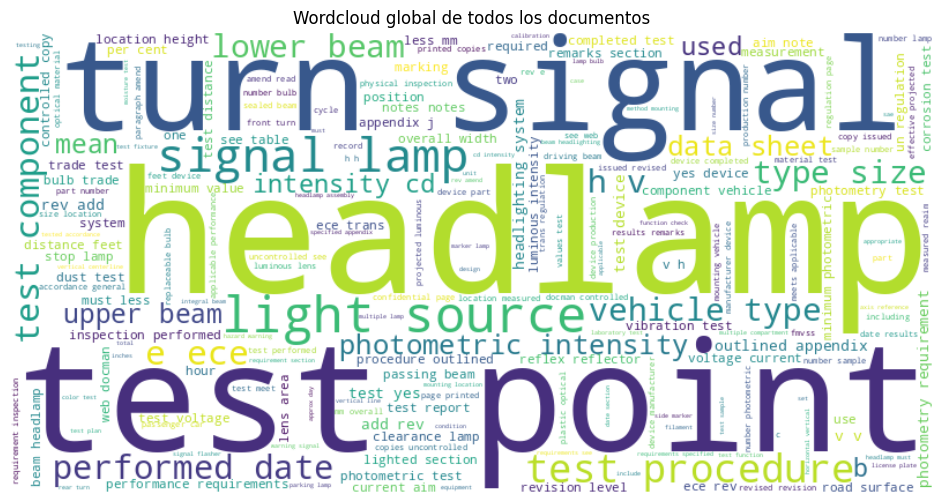

In [23]:
# -------------------------------
# Punto F2: Wordcloud global
# -------------------------------
from wordcloud import WordCloud
all_tokens = [t for doc_tokens in df_stats['tokens'] for t in doc_tokens]
text_joined = " ".join(all_tokens)

wordcloud_global = WordCloud(width=800, height=400, background_color="white").generate(text_joined)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_global, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud global de todos los documentos")
plt.show()

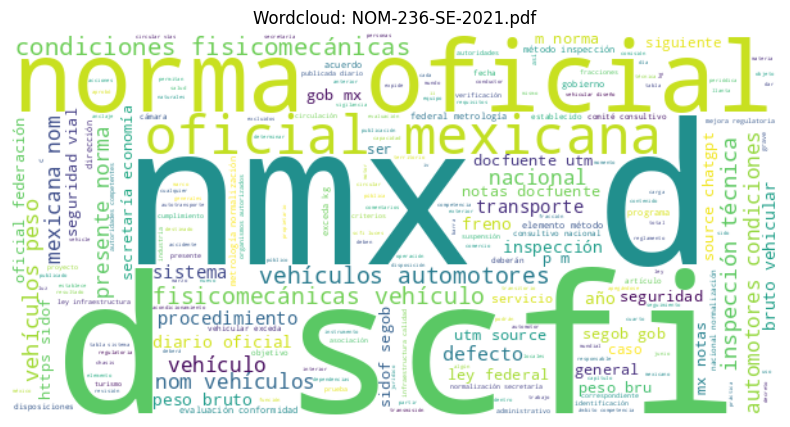

Top-20 términos: NOM-236-SE-2021.pdf


Término  Frecuencia
0         vehículos          58
1              scfi          48
2               nmx          47
3                 d          46
4           oficial          44
5             norma          39
6        inspección          38
7          mexicana          34
8          vehículo          34
9       condiciones          32
10         nacional          29
11              nom          23
12  fisicomecánicas          23
13             peso          23
14      automotores          22
15          técnica          21
16         presente          21
17              ley          20
18          federal          20
19        seguridad          20

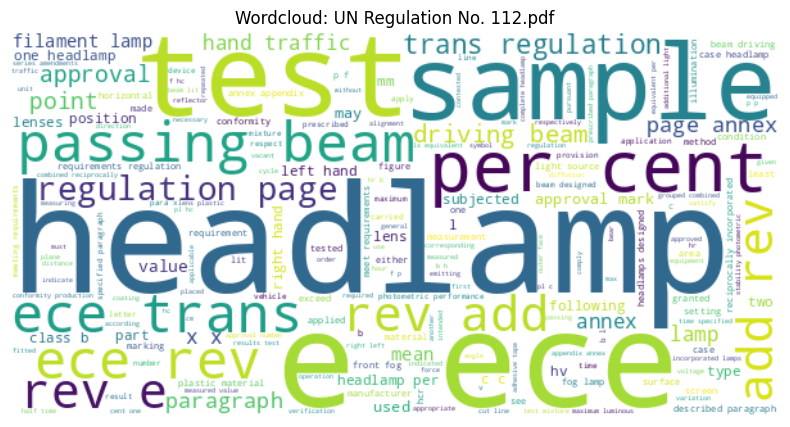

Top-20 términos: UN Regulation No. 112.pdf


Término  Frecuencia
0          shall         256
1     regulation         182
2       headlamp         180
3              e         164
4            ece         143
5            rev         141
6           beam         138
7          annex         112
8       approval         103
9      headlamps          94
10       passing          89
11          test          86
12           per          84
13     paragraph          82
14          cent          79
15             b          76
16  requirements          75
17          lamp          75
18             r          75
19         trans          71

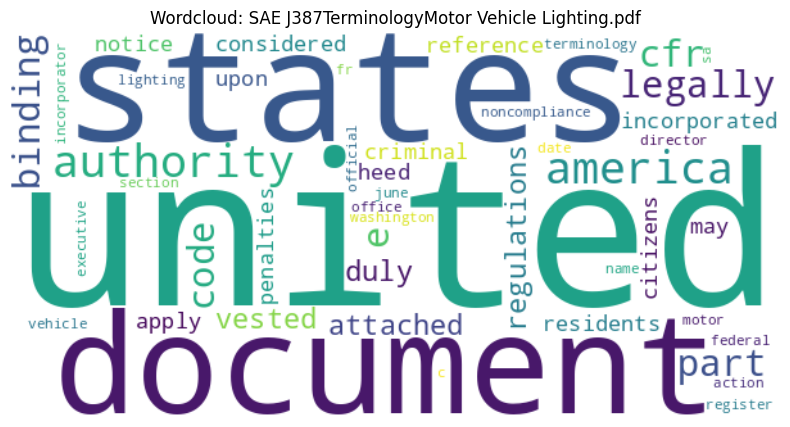

Top-20 términos: SAE J387TerminologyMotor Vehicle Lighting.pdf


Término  Frecuencia
0         united           3
1         states           3
2       document           3
3      authority           2
4        america           2
5        legally           2
6        binding           2
7           part           2
8           code           2
9              e           2
10           cfr           2
11        vested           1
12   regulations           1
13      attached           1
14          duly           1
15  incorporated           1
16     reference           1
17         shall           1
18    considered           1
19          upon           1

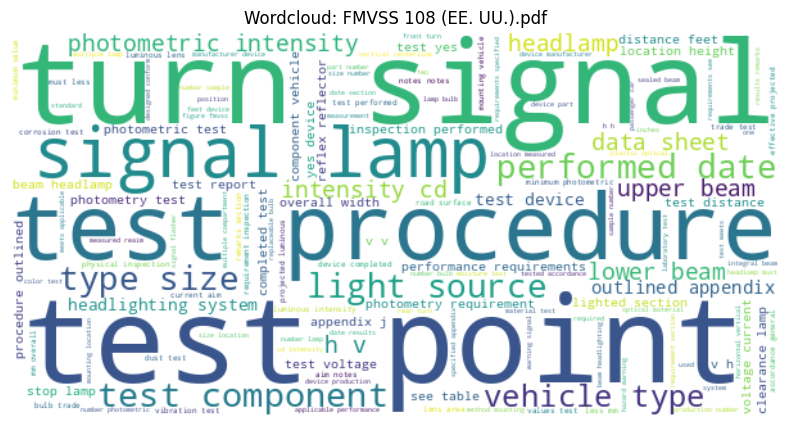

Top-20 términos: FMVSS 108 (EE. UU.).pdf


Término  Frecuencia
0           test        2642
1           lamp         948
2         device         739
3           must         649
4        vehicle         575
5   requirements         552
6       headlamp         550
7         number         538
8    photometric         514
9           beam         502
10         lamps         452
11        signal         414
12       section         409
13       minimum         395
14     intensity         382
15    photometry         373
16             v         372
17         shall         364
18             h         355
19   requirement         349

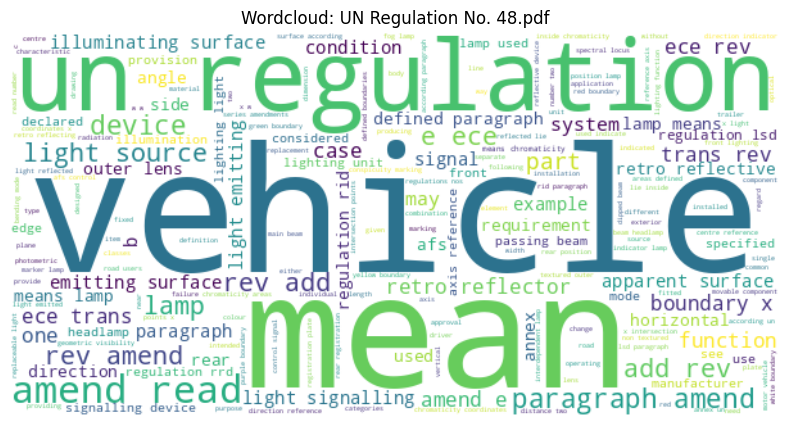

Top-20 términos: UN Regulation No. 48.pdf


Término  Frecuencia
0        light         144
1        means         144
2        amend         141
3    paragraph         141
4          rev         129
5      vehicle         110
6         lamp          99
7   regulation          96
8           un          81
9            e          79
10        read          78
11     surface          72
12         ece          65
13       retro          65
14         add          64
15       lamps          61
16       shall          59
17           x          59
18      device          54
19    lighting          53

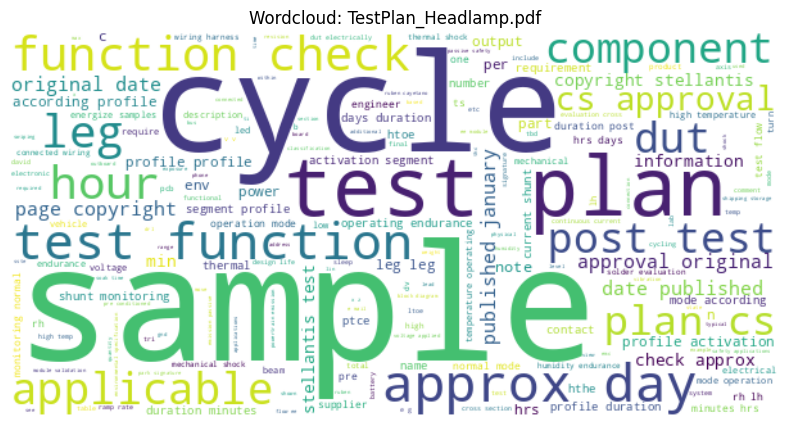

Top-20 términos: TestPlan_Headlamp.pdf


Término  Frecuencia
0         test         109
1      samples          45
2          leg          42
3      profile          35
4         plan          34
5     function          33
6         mode          33
7   stellantis          32
8            c          28
9       approx          28
10      cycles          27
11         hrs          27
12    duration          26
13          cs          25
14         dut          25
15        days          25
16    approval          24
17        date          23
18  applicable          22
19   endurance          21

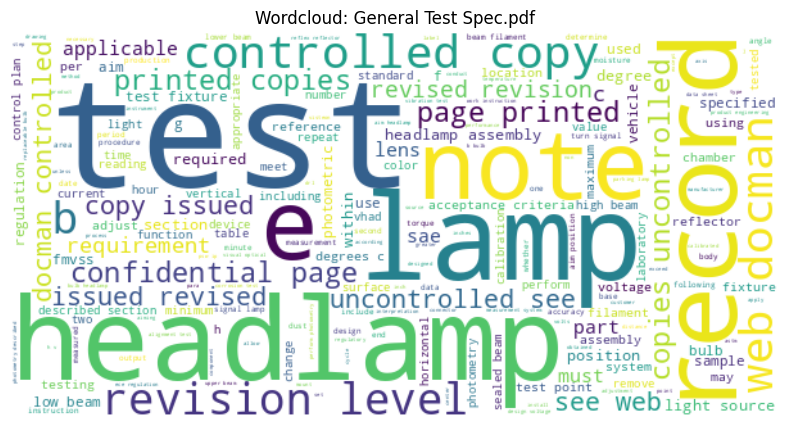

Top-20 términos: General Test Spec.pdf


Término  Frecuencia
0         test         332
1     headlamp         193
2         lamp         137
3       record         129
4            c         119
5        lamps         109
6         beam         102
7        light         100
8            b          99
9          see          95
10    position          94
11        bulb          93
12    assembly          93
13         sae          90
14         aim          89
15    revision          88
16       level          88
17  controlled          87
18        copy          83
19     revised          83

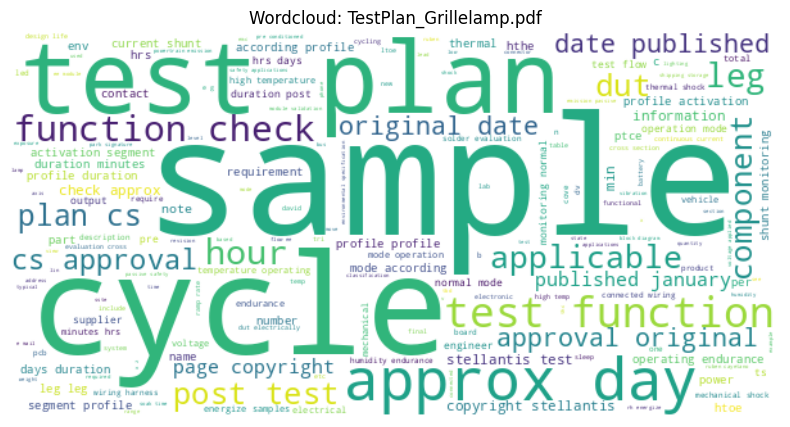

Top-20 términos: TestPlan_Grillelamp.pdf


Término  Frecuencia
0         test         106
1      samples          47
2          leg          42
3      profile          36
4         plan          33
5   stellantis          32
6     function          32
7         mode          32
8            c          28
9       approx          28
10      cycles          27
11    duration          26
12         hrs          26
13         dut          25
14        days          25
15          cs          24
16    approval          23
17        date          22
18  applicable          22
19   endurance          21

In [24]:
# -------------------------------
# Punto F3: Wordcloud por documento y Top 20 términos
# -------------------------------
for idx, row in df_stats.iterrows():
    # Wordcloud por documento
    text_doc = " ".join(row['tokens'])
    wc = WordCloud(width=600, height=300, background_color="white").generate(text_doc)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud: {row['file']}")
    plt.show()

    # Mostrar Top-20 términos
    print(f"Top-20 términos: {row['file']}")
    display(pd.DataFrame(row['top_terms'], columns=["Término", "Frecuencia"]))

Análisis multivariante de documentos (similitud / clustering)

Usa TF-IDF para representar documentos y cosine similarity para ver qué normas están más cercanas entre sí (útil para detectar grupos de normas equivalentes o que se citan).

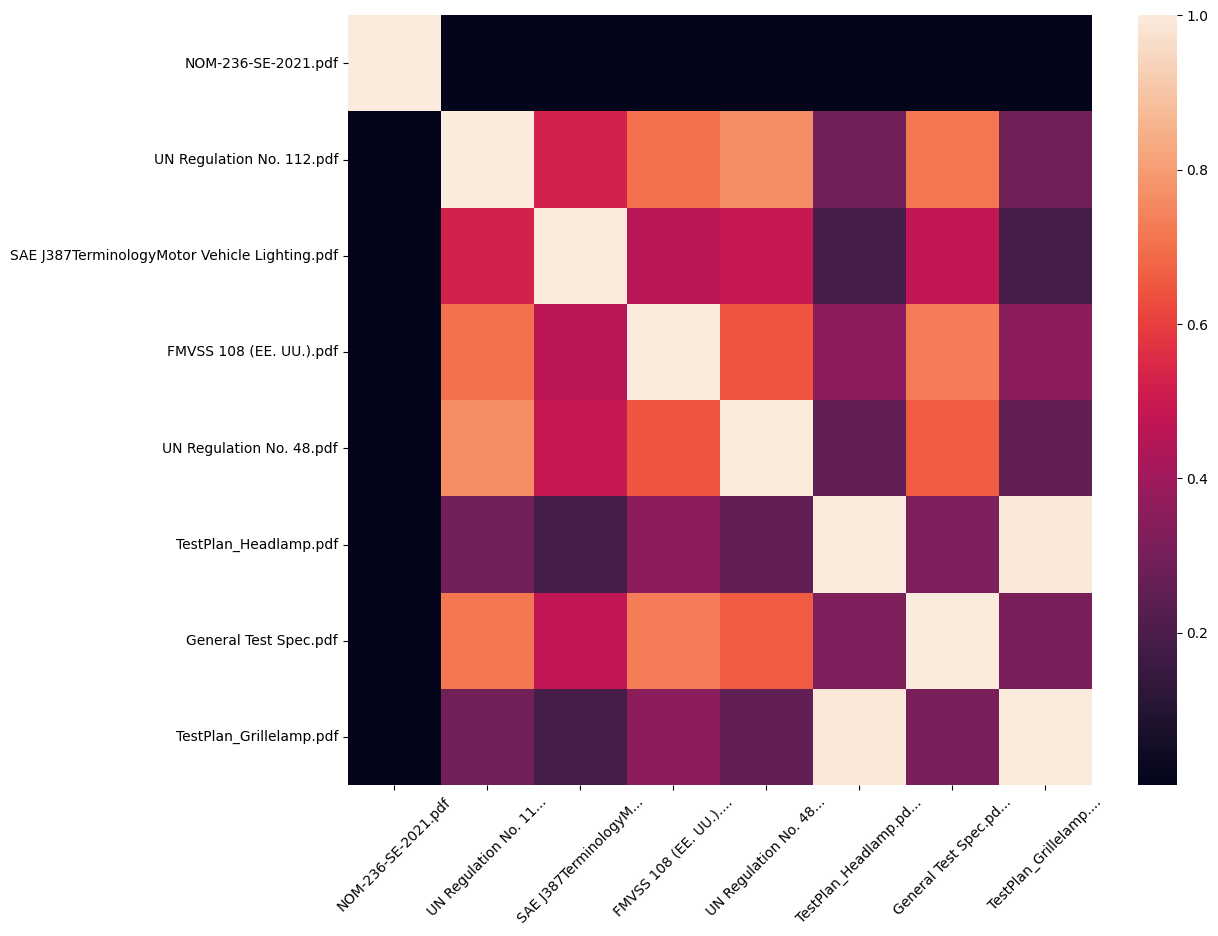

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
doc_names = list(docs.keys())
X = vectorizer.fit_transform([docs[n] for n in doc_names])
sim = cosine_similarity(X)
# conviértelo a DataFrame y grafica heatmap o dendrograma
import seaborn as sns
import matplotlib.pyplot as plt
short_names = [n[:20] + "..." if len(n) > 20 else n for n in doc_names]
plt.figure(figsize=(12, 10))
sns.heatmap(sim, xticklabels=short_names, yticklabels=doc_names)
plt.xticks(rotation=45)
plt.show()


Normalización de términos técnicos

In [33]:
# -------------------------------
# Normalización y exportación de resultados
# -------------------------------

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# -------------------------------
# 1. Crear Glosario
# -------------------------------
# Aquí definimos los términos técnicos y sus aliases para unificarlos
glossary_data = [
    {"term":"ECE R112", "canonical_term":"UNECE_R112", "aliases":"UNECE Regulation 112,R112,Reg.112"},
    {"term":"FMVSS 108", "canonical_term":"FMVSS_108", "aliases":"Federal Motor Vehicle Safety Standard 108,FMVSS108"},
    {"term":"NOM-236-SE-2021", "canonical_term":"NOM_236", "aliases":"NOM236,NOM-236"}
]

df_glossary = pd.DataFrame(glossary_data)

# Guardar glosario.csv
df_glossary.to_csv("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Avance 1/outputs/glosario.csv", index=False)
df_glossary



term canonical_term  \
0         ECE R112     UNECE_R112   
1        FMVSS 108      FMVSS_108   
2  NOM-236-SE-2021        NOM_236   

                                             aliases  
0                  UNECE Regulation 112,R112,Reg.112  
1  Federal Motor Vehicle Safety Standard 108,FMVS...  
2                                     NOM236,NOM-236

In [34]:
# -------------------------------
# 2. Reemplazar aliases por canonical_term en tokens
# -------------------------------
# Creamos un diccionario de mapeo alias -> canonical_term
alias_to_canonical = {}
for _, row in df_glossary.iterrows():
    all_aliases = [row['term']] + row['aliases'].split(",")
    for alias in all_aliases:
        alias_to_canonical[alias.lower()] = row['canonical_term']

# Función para normalizar tokens de un documento
def normalize_tokens(tokens):
    return [alias_to_canonical.get(t.lower(), t) for t in tokens]

# Aplicar normalización a todos los documentos
df_stats['tokens_norm'] = df_stats['tokens'].apply(normalize_tokens)

Exportar CSVs para entregable

In [35]:
# -------------------------------
# 3. Exportar CSVs para entregable
# -------------------------------

# 3a. Metadatos por documento
df_meta = df_stats[['file','n_words','lang']]
df_meta.to_csv("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Avance 1/outputs/df_meta.csv", index=False)

# 3b. Top términos por documento (normalizados)
top_terms_list = []
for _, row in df_stats.iterrows():
    freq = Counter(row['tokens_norm']).most_common(20)
    for term, count in freq:
        top_terms_list.append({"file": row['file'], "term": term, "frequency": count})

df_top_terms = pd.DataFrame(top_terms_list)
df_top_terms.to_csv("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Avance 1/outputs/top_terms_by_doc.csv", index=False)

Guardar gráficos para entregable

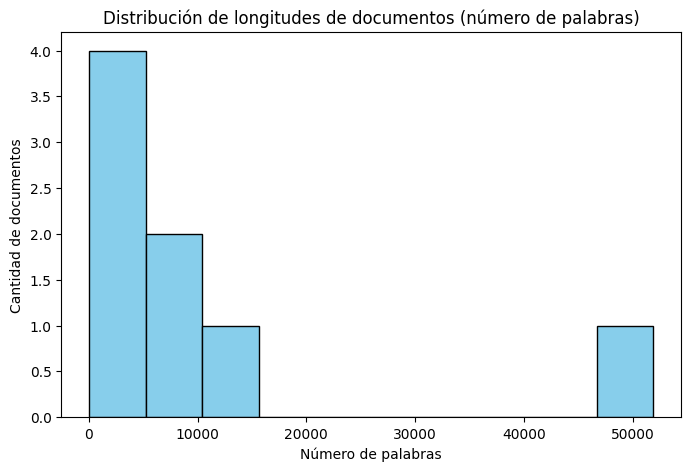

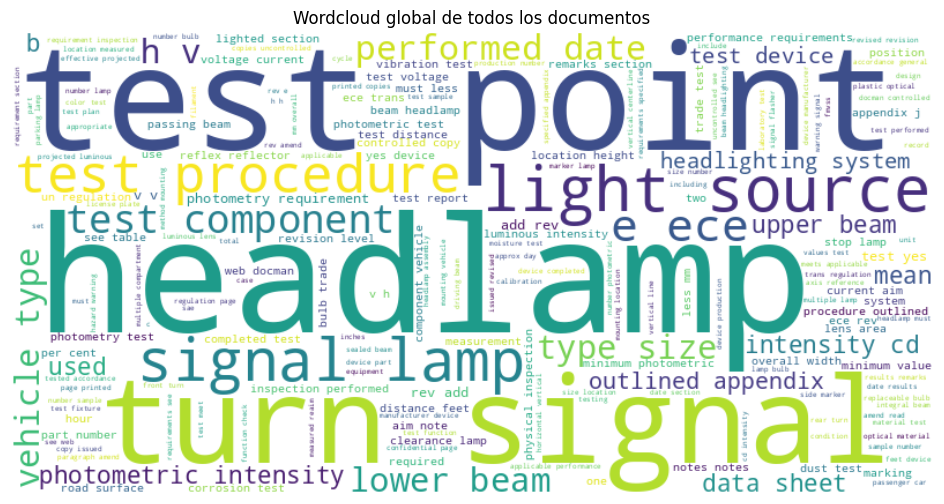

In [36]:
# -------------------------------
# 4. Guardar gráficos para entregable
# -------------------------------

# 4a. Histograma de longitudes
plt.figure(figsize=(8,5))
plt.hist(df_stats['n_words'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución de longitudes de documentos (número de palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Cantidad de documentos")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Avance 1/outputs/length_hist.png")  # Guardar en PNG
plt.show()

# 4b. Wordcloud global
all_tokens = [t for doc_tokens in df_stats['tokens_norm'] for t in doc_tokens]
text_joined = " ".join(all_tokens)
wordcloud_global = WordCloud(width=800, height=400, background_color="white").generate(text_joined)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_global, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud global de todos los documentos")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/MNA/TC5035 - Proyecto Integrador/Avance 1/outputs/outputswordcloud_all.png")  # Guardar en PNG
plt.show()

# **Conclusión**

El análisis exploratorio de los archivos PDF permitió comprender la naturaleza, estructura y variabilidad de la información contenida en las normas y documentos técnicos relacionados con las pruebas de lámparas automotrices. Este primer paso evidenció que la principal necesidad no está en limpiar datos numéricos tradicionales, sino en diseñar un proceso robusto de extracción, estandarización y organización de texto, que permita convertir documentos no estructurados en datos útiles para el modelado posterior.

En relación con los objetivos planteados y por la naturaleza del proyecto, la reducción de dimensionalidad y selección de características relevantes debe enfocarse en técnicas de procesamiento de lenguaje natural (NLP), como la detección de términos clave, eliminación de redundancias y normalización de conceptos técnicos. Asimismo, se reconoció que los principales problemas a abordar provienen de las diferencias entre los documentos (formato, estructura, idioma y calidad del texto), lo cual hace imprescindible un preprocesamiento exhaustivo antes de entrenar modelos.

En conclusión, este EDA permitió sentar las bases para construir un conjunto de datos textual depurado y representativo que servirá como entrada para el desarrollo de una AGI orientada a brindar asistencia inteligente en pruebas de lámparas automotrices, facilitando la consulta, interpretación y aplicación de normas técnicas en el ámbito industrial.